## Long Short Term Memory in Stonktastic
***

### Summary:
In Stonktastic, we use three machine learning algorithum: Polynomial Regression, Long-Term Short-Term Memory and Random Forest.

Long Short Term Memory (LSTM) is a type of recurrent neural network. LSTM consists of memory blocks that each have memory cells. The cell transfers relative information down the "chain". Each memory block as well has an input gate, output gate, and forget gate. These gates can write, read, and reset operations. The cell will remember values over time and these gates are what controls our flow of information.
The purpose for using an LSTM is for their capability of learning long-term dependency. Due to how the cells carry information and our control of gates, we can feed all of our data over larger periods of time and information that is fed earlier can end up at later time steps in our model.
Over our historical stock data, our model will be able to give us more accurate predictions with this long-term capability.

### Stonktastic's use of Long Short Term Memory
LSTM in Stonktastic uses sklearn's following libraries for machine learning calculations:
- *Ensemble* library for the LSTM model to preform the actual machine learning calculations
- *Metrics* : Used to get the metrics of the model, namely *mean squared error

##### Data Split
We split the data not by randomly selecting 80/20 of the data to fall under Train/Test but instead cut off the last 20% to be used as the testing data itself. 

##### Saving and Loading
To save the data off after our initial calculations are preformed we use the *Pickle* library and save off the results of any calculations to the SQL lite database.

### Long Short Term Memory Optimization
With this experiment we are creating an LSTM model to predict the pricing of the SMP500 over the period of seven years. Our experiment will be testing three different major parts of the model to figure out how to optimize the model. 

#### Variable Optimization
For the first section we will be testing the best combination of variables for the model to learn from. We have given the model 14 different variables, and the test will find out what set of variables we should use based on the accuracy and how long it took the model to complete that set. The value of each is done by ranking options with the results/time taken to preform calculations.

#### Hyper-Parameter Optimization
The second section we will be testing is the hyper-parameter optimization, which will be done using Talos. In this section we will be handing Talos a dictionary of different hyper-parameters for it to feed the model such as dropout, units, loss, or batch size. The model will loop through each possible combination of hyper parameters letting us compare the different combinations and finding the model with the best accuracy and loss.

#### Epoch Optimization
The third section we will be taking a look at is the number of epochs to run. We will be using the callback function of early stopping to determine the optimal point in when to stop our model. The model is given a set number of 100 epochs to run, while the model is running if the model does not see a better loss value over a "grace" period of 15 epochs the model will stop itself telling us how many epochs was the optimal number. 



#### Preping for Analysis

In [31]:
import sys
sys.path.append('../')

import stonkCode
import pandas as pd
import seaborn as sns

sampleNum = 200

#### Pull Optimization Data

In [32]:
# epochOpt = stonkCode.optimization.runMemoryOptimization(stonkCode.config.stockToOpt)
epochOpt = pd.read_csv('optEpochSet.csv')
memoryOpt = pd.read_csv('memSubSet.csv')

print(memoryOpt)

      Unnamed: 0                                             subset  \
0            589  ('MACDHist', 'BBUpperBand', 'BBMiddleBand', 'B...   
1            595  ('MACDHist', 'BBUpperBand', 'BBLowerBand', 'EM...   
2            590  ('MACDHist', 'BBUpperBand', 'BBMiddleBand', 'E...   
3            423  ('RSI', 'MACDHist', 'BBUpperBand', 'EMA', 'Clo...   
4            303  ('SAR', 'MACDHist', 'BBUpperBand', 'EMA', 'Clo...   
...          ...                                                ...   
4012        3772  ('SAR', 'RSI', 'CCI', 'MACDHist', 'BBLowerBand...   
4013        3764  ('SAR', 'RSI', 'CCI', 'MACDHist', 'BBMiddleBan...   
4014        2220  ('RSI', 'EMA', 'Chaikin', 'StochK', 'StochD', ...   
4015        3899  ('RSI', 'CCI', 'MACDHist', 'BBUpperBand', 'BBL...   
4016        3803  ('SAR', 'RSI', 'MACDHist', 'BBUpperBand', 'BBM...   

                                          results        time     score  \
0      [0.005113869905471802, 0.9159420132637024]    9.116621  0.100469 

### Memory Variables
We will be using the *Optimization* part of the script to look at the variables and graph the results of our choices


### Exploring Subset of the Initial Variables

In [33]:
df = memoryOpt
df.sort_values(by='score', ascending=False, inplace=True)
df = df.reset_index(drop=True)

optSubSet = df['subset'][0]

print(f"Optimized Subset for Long Short Term Memory : {optSubSet}")

Optimized Subset for Long Short Term Memory : ('MACDHist', 'BBUpperBand', 'BBMiddleBand', 'BBLowerBand', 'Close', 'Date')


In [ ]:
df

#### Explore Variable Weight

In [34]:
memoryVariables = ["SAR","RSI","CCI","MACDHist", "BBUpperBand",
                    "BBMiddleBand","BBLowerBand","EMA", "Chaikin",
                    "StochK","StochD","WILLR"]
RowCount        = [0,0,0,0,0,0,0,0,0,0,0,0] 


memoryCounterDataframe = pd.DataFrame(RowCount,index=memoryVariables, columns=['Count'])

In [35]:
for idx, subsetList in enumerate(memoryOpt["subset"].values.tolist()):
    for variable in memoryVariables:
        if variable in subsetList:
            memoryCounterDataframe.at[variable,'Count'] = (  memoryCounterDataframe.at[variable, 'Count'] + 
                                                             int(len(memoryOpt) - idx)  )
            

In [36]:
memoryCounterDataframe.sort_values(by='Count', ascending=False, inplace=True)

#Normalize Data
lowestScore = memoryCounterDataframe['Count'].iloc[-1]
memoryCounterDataframe['Count'] = memoryCounterDataframe['Count'] - lowestScore

# Get percentages of Data
countSum = memoryCounterDataframe["Count"].sum()
memoryCounterDataframe['Count'] = memoryCounterDataframe['Count'].multiply((1/countSum)*100)

memoryCounterDataframe.drop(memoryCounterDataframe.tail(1).index, inplace = True) 

print(memoryCounterDataframe)

                  Count
MACDHist      20.356559
EMA           13.437808
RSI           12.631156
SAR           11.473599
BBUpperBand   11.282778
BBMiddleBand   9.771985
CCI            8.617085
BBLowerBand    8.112927
Chaikin        3.206443
StochD         0.972997
StochK         0.136665


#### Exploring the relationship between number of variables and results

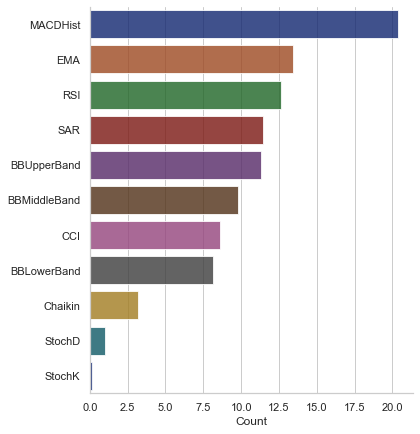

In [37]:
g = sns.catplot(
    data=memoryCounterDataframe, kind="bar",
    x="Count", y=memoryCounterDataframe.index.values, palette="dark", alpha=0.8, height=6,
    legend=False
)


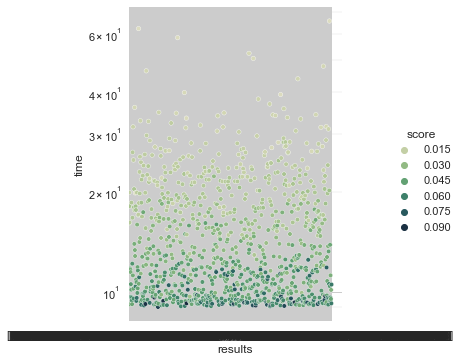

In [38]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.6, as_cmap=True)

g = sns.relplot(
    data=memoryOpt.sample(1000),
    x="results", y="time",hue="score",
    palette=cmap, s=20
)

g.set(xlim=(0.993, None))

g.set(yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)

#### Hyper-Parameter Exploration
With this next section we will be testing out different hyper-parameters in a model over 20 epochs with the same list of variables. We want to know which combination of parameters will give us the best accuracy for our model. We will be ignoring the time it takes to complete each set of epochs.

In [39]:
hyperdf = pd.read_csv('memoryHyperSet.csv')
hyperdf.drop(columns=['Unnamed: 0','start', 'end', 'duration', 'round_epochs', 'val_loss', 'val_accuracy'], axis=1, inplace=True)

Test results sorted by the best accuracy:

In [40]:
hyperdf = hyperdf.sort_values(by='accuracy', ascending=False)
hyperdf.head()

,loss,accuracy,batch_size,dropout,epochs,kernal_initializer,loss.1,optimizer,units
8,0.009713,0.502591,20,0.2,20,glorot_uniform,mean_squared_error,RMSprop,50
16,0.073165,0.500000,20,0.2,20,glorot_uniform,mean_absolute_error,RMSprop,40
14,0.069813,0.493523,20,0.2,20,glorot_uniform,mean_absolute_error,Nadam,50
11,0.067288,0.490933,20,0.2,20,glorot_uniform,mean_absolute_error,Adam,50
2,0.009765,0.489637,20,0.2,20,glorot_uniform,mean_squared_error,Adam,50


Test results sorted by the best loss value:

In [41]:
hyperdf = hyperdf.sort_values(by='loss', ascending=True)
hyperdf.head()

,loss,accuracy,batch_size,dropout,epochs,kernal_initializer,loss.1,optimizer,units
8,0.009713,0.502591,20,0.2,20,glorot_uniform,mean_squared_error,RMSprop,50
2,0.009765,0.489637,20,0.2,20,glorot_uniform,mean_squared_error,Adam,50
7,0.010276,0.479275,20,0.2,20,glorot_uniform,mean_squared_error,RMSprop,40
5,0.010533,0.463731,20,0.2,20,glorot_uniform,mean_squared_error,Nadam,50
1,0.010731,0.455959,20,0.2,20,glorot_uniform,mean_squared_error,Adam,40


For this test our best run based on our accuracy and loss was:

In [42]:
hyperdf.iloc[0]

loss                          0.00971283
accuracy                        0.502591
batch_size                            20
dropout                              0.2
epochs                                20
kernal_initializer        glorot_uniform
loss.1                mean_squared_error
optimizer                        RMSprop
units                                 50
Name: 8, dtype: object

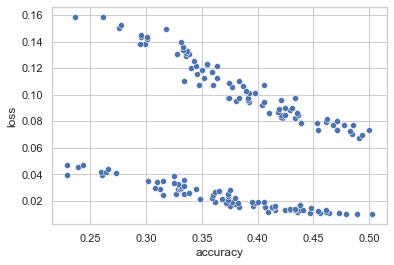

In [54]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.6, as_cmap=True)
g = sns.scatterplot(
    data = hyperdf,
    x = 'accuracy',
    y = 'loss',
    palette = cmap,
)


#### Epoch Exploration
We will be using the *Optimization* part of the script to look at the value of cost function for our cross-validation, as well as the value of cost function for our training data. We want to know at which epoch our algorithm should stop at by determining when we are over fitting our model.

In [44]:
epochdf = epochOpt
epochdf.rename(columns= {'value': 'Loss', 'epoch': 'Epoch'})
print(epochOpt)
# epochdf.dtypes

     Epoch          Loss     Value
0        1  Testing Loss  0.087866
1        2  Testing Loss  0.041353
2        3  Testing Loss  0.033724
3        4  Testing Loss  0.028414
4        5  Testing Loss  0.024925
..     ...           ...       ...
127     62      Val Loss  0.004761
128     63      Val Loss  0.004717
129     64      Val Loss  0.004689
130     65      Val Loss  0.004789
131     66      Val Loss  0.004720

[132 rows x 3 columns]


[None]

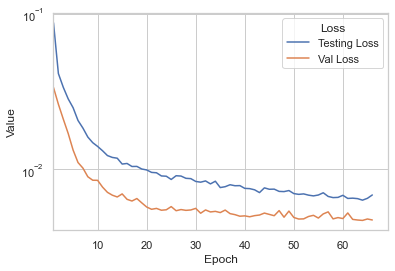

In [45]:
sns.set_theme(style="whitegrid")

g = sns.lineplot(data=epochdf, x='Epoch', y='Value', hue='Loss')
g.set(xlim=(0.993, None))

g.set(yscale="log")

In [46]:
length = len(epochdf.index)
print("The model saved the best data off at epoch:", length/2-15)

The model saved the best data off at epoch: 51.0


### Results

##### Variable Subsets
We found that the subset : ('MACDHist', 'BBUpperBand', 'BBMiddleBand', 'BBLowerBand', 'Close', 'Date') preformed with the highest level of accuracy for the time required. This is the subset of variables that we use in the main calculations though if one required either higher levels of accuracy or a faster processing time, the variables could be tweaked.

#### Hyper-Parameter Set
We found that the best set of hyper-parameters : (Batch Size: 20, Dropout: 0.2, Epochs: 20, Kernel Initializer: glorot_uniform, Loss: mean_squared_error, Optimizer: RMSprop, Units: 50) performed with the highest accuracy will also having the lowest loss value. This is the set of hyper-parameters that we will use in the main calculations. This test does not take in to account a varying amount of epochs, different variables between tests, and the time to complete each test.


##### Optimal Epochs

In the above graph, we can see that as the number of epochs increased, our training loss and validation loss are decreasing as our number of epochs increases. This along with the early stopping function in Keras can help us to determine when we are over-fitting our model. With this test run we have determined that epoch with the best data is epoch 51, the model ran for 66 epochs before early stopping, and the model had a patience of 15 epochs to see if we have an increase in accuracy.